In [1]:
import re
import nltk
import textstat
import pandas as pd
import numpy as np
import datetime
import statsmodels.api as sm
from collections import Counter
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import pymongo

nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package wordnet to E:\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to E:\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
def connect_mongo(query={},host='localhost', port=27017, username=None, password=None, no_id=True):
    if username and password:
        mongo_uri = "mongodb://%s:%s@%s:%s/%s" % (username, password, host, port, db)
        client = pymongo.MongoClient(mongo_uri)
    else:
        client = pymongo.MongoClient(host, port)
    return client
    
client = connect_mongo()
collect = client.issues.first_issues
tmp_collect = client.gfibot.resolved_issue
# db = collect.find({"resolver_commit_num":{"$gte": 0, "$lte": 2}}).sort("closed_at",pymongo.ASCENDING)

In [3]:
df = pd.DataFrame(list(collect.find()))

In [4]:
otc = set()
cnt = 0
for data in collect.find():
    if tmp_collect.count_documents({"owner":data["owner"],"name":data["name"],"resolver":data["resolver"]}) <= 1:
#         print(data["owner"], data["name"], data["resolver"],tmp_collect.count_documents({"owner":data["owner"],"name":data["name"],"resolver":data["resolver"]}))
        otc.add(data["owner"]+"/"+data["name"]+"/"+data["resolver"])
    else:
        res = tmp_collect.find({"owner":data["owner"],"name":data["name"],"resolver":data["resolver"]}).sort([("resolved_at",-1)]).skip(0).limit(1)
        for item in res:
            if (item["resolved_at"]-data["closed_at"]).days<1:
                otc.add(item["owner"]+"/"+item["name"]+"/"+item["resolver"])

In [5]:
len(otc)

8427

In [6]:
otc_iss, notc_iss = df[(df.owner+"/"+df.name+"/"+df.resolver).isin(otc)], df[~(df.owner+"/"+df.name+"/"+df.resolver).isin(otc)]

In [7]:
len(otc_iss), len(notc_iss)

(10892, 4049)

In [8]:
metrics = [
    "len_title", "len_body", 
    "n_code_snips", "n_urls", "n_imgs", 
    "coleman_liau_index", 
    "flesch_reading_ease", "flesch_kincaid_grade", "automated_readability_index",     
]

In [9]:
otc_iss[metrics].describe()

,len_title,len_body,n_code_snips,n_urls,n_imgs,coleman_liau_index,flesch_reading_ease,flesch_kincaid_grade,automated_readability_index
count,10892.000000,10892.000000,10892.000000,10892.000000,10892.000000,10892.000000,10892.000000,10892.000000,10892.000000
mean,7.736412,103.321796,0.762303,1.503764,0.010834,16.535481,49.939311,9.689120,17.517086
std,3.281546,101.163983,1.306897,3.339742,0.135757,30.831954,79.857317,11.226998,28.905172
min,1.000000,0.000000,0.000000,0.000000,0.000000,-28.010000,-4550.100000,-15.700000,-6.900000
25%,5.000000,37.000000,0.000000,0.000000,0.000000,9.710000,44.410000,6.800000,10.300000
50%,7.000000,75.000000,0.000000,1.000000,0.000000,12.440000,57.870000,8.700000,13.400000
75%,10.000000,142.000000,1.000000,2.000000,0.000000,16.600000,68.200000,11.100000,17.800000
max,40.000000,2504.000000,18.000000,274.000000,6.000000,1925.410000,206.840000,650.600000,1609.300000


In [10]:
notc_iss[metrics].describe()

,len_title,len_body,n_code_snips,n_urls,n_imgs,coleman_liau_index,flesch_reading_ease,flesch_kincaid_grade,automated_readability_index
count,4049.000000,4049.000000,4049.000000,4049.000000,4049.000000,4049.000000,4049.000000,4049.000000,4049.000000
mean,7.612744,99.076068,0.705359,1.288713,0.010373,15.011437,54.656056,9.068684,16.239195
std,3.221361,126.011066,1.303072,2.168398,0.129193,15.834378,44.569108,6.748208,15.869130
min,1.000000,0.000000,0.000000,0.000000,0.000000,-15.810000,-978.590000,-15.700000,-4.400000
25%,5.000000,35.000000,0.000000,0.000000,0.000000,9.570000,45.010000,6.600000,10.200000
50%,7.000000,71.000000,0.000000,1.000000,0.000000,12.530000,58.620000,8.600000,13.500000
75%,9.000000,137.000000,1.000000,2.000000,0.000000,16.630000,69.110000,11.000000,17.800000
max,34.000000,5610.000000,36.000000,61.000000,3.000000,291.300000,206.840000,150.000000,295.100000


In [11]:
for metric in metrics:
    print(f"{metric:30} {mannwhitneyu(otc_iss[metric], notc_iss[metric])}")

len_title                      MannwhitneyuResult(statistic=21594126.0, pvalue=0.025048848587122967)
len_body                       MannwhitneyuResult(statistic=21353051.0, pvalue=0.00145154860230282)
n_code_snips                   MannwhitneyuResult(statistic=21651693.0, pvalue=0.024792098069734522)
n_urls                         MannwhitneyuResult(statistic=20743280.5, pvalue=2.839968124617133e-09)
n_imgs                         MannwhitneyuResult(statistic=22038918.0, pvalue=0.37291824140301344)
coleman_liau_index             MannwhitneyuResult(statistic=21865428.0, pvalue=0.21439103568899498)
flesch_reading_ease            MannwhitneyuResult(statistic=21483233.0, pvalue=0.00771252605531581)
flesch_kincaid_grade           MannwhitneyuResult(statistic=21627310.5, pvalue=0.03534201865927662)
automated_readability_index    MannwhitneyuResult(statistic=21926032.0, pvalue=0.2971322029744101)


In [12]:
list(map(
    lambda x: (x[0], x[1] / len(otc_iss)), 
    sorted(Counter(sum(otc_iss.labels, [])).items(), key=lambda x: -x[1])[0:20]
))

[('good first issue', 0.17223650385604114),
 ('help wanted', 0.1136614028644877),
 ('bug', 0.10705104663973558),
 ('Bug', 0.08272126331252296),
 ('enhancement', 0.053433712816746234),
 ('waffle:review', 0.024329783327212633),
 ('Docs', 0.023411678295997062),
 ('accepted', 0.022769004774146163),
 ('Effort Low', 0.02157546823356592),
 ('Easy', 0.01973925817113478),
 ('easy', 0.019555637164891664),
 ('Documentation', 0.01882115313991921),
 ('feature-request', 0.017627616599338966),
 ('docs', 0.017076753580609623),
 ('rule', 0.016709511568123392),
 ('<Bug>', 0.016066838046272493),
 ('up-for-grabs', 0.015607785530664707),
 ('hacktoberfest', 0.015056922511935366),
 ('type: bug', 0.01459786999632758),
 ('has PR', 0.012853470437017995)]

In [13]:
list(map(
    lambda x: (x[0], x[1] / len(notc_iss)), 
    sorted(Counter(sum(notc_iss.labels, [])).items(), key=lambda x: -x[1])[0:20]
))

[('good first issue', 0.20671770807606815),
 ('bug', 0.14596196591751048),
 ('help wanted', 0.10570511237342553),
 ('Bug', 0.08150160533465053),
 ('enhancement', 0.05828599654235614),
 ('feature-request', 0.03013089651765868),
 ('Good First Issue', 0.02543837984687577),
 ('Effort Low', 0.022721659669054088),
 ('accepted', 0.019510990367992097),
 ('Docs', 0.01901704124475179),
 ('easy', 0.018523092121511483),
 ('Easy', 0.017782168436651025),
 ('Hacktoberfest', 0.017288219313410718),
 ('<Bug>', 0.017288219313410718),
 ('in progress', 0.016794270190170414),
 ('rule', 0.016300321066930107),
 ('Documentation', 0.016300321066930107),
 ('type: bug', 0.014818473697209187),
 ('effort/small', 0.014571499135589035),
 ('Needs Tests', 0.013336626327488268)]

In [14]:
counter1 = Counter()
for cat in otc_iss.label_category:
    counter1.update(cat)
total = sum(counter1.values())
for k, v in counter1.items():
    counter1[k] = v / total
counter1

Counter({'bug': 0.2465564738292011,
         'feature': 0.05404310484524388,
         'test': 0.023091881380651436,
         'build': 0.011505428617728084,
         'doc': 0.08215848322800194,
         'coding': 0.016042780748663103,
         'enhance': 0.07672986549991898,
         'gfi': 0.3331712850429428,
         'medium': 0.021147301895964997,
         'major': 0.04885755955274672,
         'triaged': 0.07243558580456977,
         'untriaged': 0.0142602495543672})

In [15]:
counter2 = Counter()
for cat in notc_iss.label_category:
    counter2.update(cat)
total = sum(counter2.values())
for k, v in counter2.items():
    counter2[k] = v / total
counter2

Counter({'bug': 0.2602739726027397,
         'feature': 0.06103948428686543,
         'test': 0.021958098307816278,
         'build': 0.01732473811442385,
         'doc': 0.06385979049153909,
         'coding': 0.02115229653505238,
         'enhance': 0.07695406929895246,
         'gfi': 0.3450846091861402,
         'medium': 0.015914585012087028,
         'major': 0.036663980660757454,
         'triaged': 0.06486704270749395,
         'untriaged': 0.014907332796132152})

Text(0, 0.5, 'ratio')

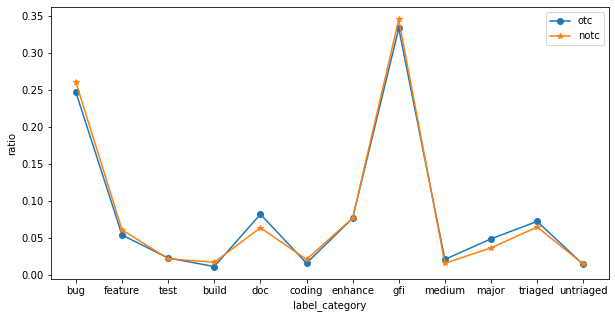

In [16]:
plt.figure(figsize=(10,5))
# x轴
x_counter = counter1.keys()
# 第一条折
y_counter1 = counter1.values()
y_counter2 = counter2.values()

plt.plot(x_counter, y_counter1, marker='o',label='otc')
plt.plot(x_counter, y_counter2, marker='*',label='notc')
plt.legend()  # 让图例生效
 
# 显示标签，如果不加这句，即使在plot中加了label='一些数字'的参数，最终还是不会显示标签
plt.legend(loc="upper right")
plt.xlabel('label_category')
plt.ylabel('ratio')

In [35]:
otc_events = dict(map(
    lambda x: (x[0], x[1] / len(otc_iss)), 
    sorted(Counter(sum(otc_iss.events, [])).items(), key=lambda x: -x[1])[0:20]
))

In [38]:
notc_events = dict(map(
    lambda x: (x[0], x[1] / len(notc_iss)), 
    sorted(Counter(sum(notc_iss.events, [])).items(), key=lambda x: -x[1])[0:20]
))

True


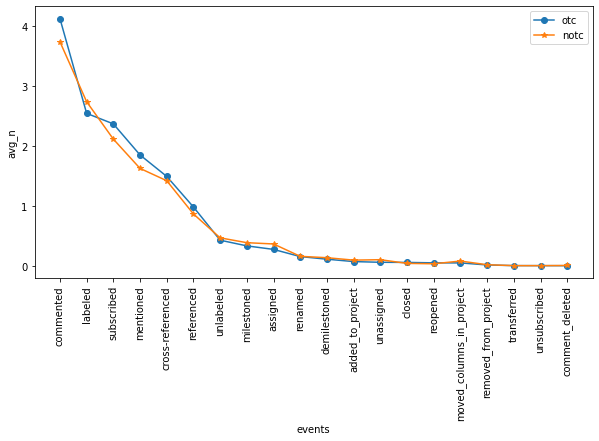

In [45]:
plt.figure(figsize=(10,5))
# x轴
x_counter = otc_events.keys()
x_counter1 = notc_events.keys()
print(x_counter == x_counter1)
# y轴
y_counter1 = otc_events.values()
y_counter2 = [notc_events[key] for key in x_counter]

plt.plot(x_counter, y_counter1, marker='o',label='otc')
plt.plot(x_counter, y_counter2, marker='*',label='notc')
plt.legend()  # 让图例生效
 
plt.legend(loc="upper right")
plt.xlabel('events')
plt.ylabel('avg_n')
res = plt.xticks(rotation=90)

In [19]:
same1 = list(1 if otc_iss.loc[x].reporter_feat["name"] == otc_iss.loc[x].resolver else 0 for x in otc_iss.index)
same2 = list(1 if notc_iss.loc[x].reporter_feat["name"] == notc_iss.loc[x].resolver else 0 for x in notc_iss.index)

In [20]:
print(sum(same1)/len(same1),sum(same2)/len(same2))
print(mannwhitneyu(same1, same2))

0.38753213367609257 0.27068411953568783
MannwhitneyuResult(statistic=19474255.5, pvalue=1.999072116707632e-40)


In [47]:
metrics_bg = [
    "n_stars", "n_pulls", "n_commits", "n_contributors", "n_closed_issues", "n_open_issues", "r_open_issues"
]

In [48]:
otc_iss[metrics_bg].describe()

,n_stars,n_pulls,n_commits,n_contributors,n_closed_issues,n_open_issues,r_open_issues
count,10892.000000,10892.000000,10892.000000,10892.000000,10892.000000,10892.000000,10892.000000
mean,14940.805362,6615.854848,16058.257345,674.929490,6300.897907,1018.086669,0.166612
std,14773.338262,7544.576970,18349.280726,748.843886,7620.832120,1385.537218,0.118561
min,0.000000,0.000000,0.000000,0.000000,5.000000,1.000000,0.000297
25%,2309.000000,1825.250000,4270.000000,161.000000,1654.750000,215.000000,0.067582
50%,8172.000000,3867.000000,10017.000000,401.000000,3798.500000,495.000000,0.163725
75%,27079.000000,8540.500000,20620.000000,947.000000,9085.500000,1229.000000,0.223842
max,40019.000000,86504.000000,115083.000000,4309.000000,100384.000000,29622.000000,0.998463


In [49]:
notc_iss[metrics_bg].describe()

,n_stars,n_pulls,n_commits,n_contributors,n_closed_issues,n_open_issues,r_open_issues
count,4049.000000,4049.000000,4049.000000,4049.000000,4049.000000,4049.000000,4049.000000
mean,13394.559150,7397.357372,16979.990121,644.687577,7042.482835,1259.487034,0.192124
std,14312.451579,9575.991243,18868.180672,751.814006,8932.689765,1627.871165,0.142420
min,0.000000,5.000000,0.000000,0.000000,1.000000,1.000000,0.005950
25%,2004.000000,1656.000000,4144.000000,138.000000,1529.000000,237.000000,0.093139
50%,6350.000000,4062.000000,11031.000000,357.000000,3939.000000,641.000000,0.179214
75%,23860.000000,9305.000000,21829.000000,841.000000,9645.000000,1655.000000,0.240618
max,40019.000000,88678.000000,113062.000000,4371.000000,118634.000000,29552.000000,0.993978


In [51]:
for metric in metrics_bg:
    print(f"{metric:30} {mannwhitneyu(otc_iss[metric], notc_iss[metric])}")
# otc选的项目star，contributors 更多
# notc选的项目commits，open issue数，open issue比例 更多

n_stars                        MannwhitneyuResult(statistic=21052182.5, pvalue=1.005238035404567e-05)
n_pulls                        MannwhitneyuResult(statistic=21777701.0, pvalue=0.12188025237873412)
n_commits                      MannwhitneyuResult(statistic=21425435.0, pvalue=0.003805198437677794)
n_contributors                 MannwhitneyuResult(statistic=21294100.5, pvalue=0.0006203926767677596)
n_closed_issues                MannwhitneyuResult(statistic=21694179.0, pvalue=0.0639975299265374)
n_open_issues                  MannwhitneyuResult(statistic=20137786.0, pvalue=1.6240676605583688e-16)
r_open_issues                  MannwhitneyuResult(statistic=19909907.5, pvalue=3.235105159188478e-20)
